<a href="https://colab.research.google.com/github/jang-hyunjun/icml_hyunjun/blob/main/vqvae_%ED%8A%9C%EB%A7%81%ED%85%8C%EC%8A%A4%ED%8A%B8_%EB%8B%A8%EC%9D%BC%EC%A0%95%EB%B3%B4%EB%9F%89%EC%8B%A4%ED%97%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 튜링테스트 인간 vs AI 단일정보량 실험

# 정보량

In [ ]:
import os
import re
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModel, AutoModelForMaskedLM
from google.colab import drive
from scipy.stats import entropy, wasserstein_distance
from scipy.spatial.distance import jensenshannon


# 환경 설정
drive.mount('/content/drive')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

BATCH_SIZE = 32

In [ ]:
# 모델 불러오기
EXPERIMENTS = [
    {"name": "BERT",       "hf_id": "bert-base-uncased",             "path": "/content/drive/MyDrive/VQVAE_Comparison_Final/Classifier_Vocab_BERT_Best.pth"},
    {"name": "ModernBERT", "hf_id": "answerdotai/ModernBERT-base",   "path": "/content/drive/MyDrive/VQVAE_Comparison_Final/Classifier_Vocab_ModernBERT_Best.pth"},
    {"name": "RoBERTa",    "hf_id": "roberta-base",                  "path": "/content/drive/MyDrive/VQVAE_Comparison_Final/Classifier_Vocab_RoBERTa_Best.pth"},
    {"name": "ELECTRA",    "hf_id": "google/electra-base-discriminator", "path": "/content/drive/MyDrive/VQVAE_Comparison_Final/Classifier_Vocab_ELECTRA_Best.pth"}
]

In [ ]:
# 모델 클래스 정의
class VQVAE_Original_Structure(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=518, num_embeddings=8000, embedding_dim=64):
        super().__init__()
        self.encoder_body = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.LeakyReLU(0.1),
            nn.Linear(hidden_dim, 216), nn.LeakyReLU(0.1),
            nn.Linear(216, 108), nn.LeakyReLU(0.1),
            nn.Linear(108, 64), nn.LeakyReLU(0.1),
            nn.Linear(64, embedding_dim)
        )
        self.encoder_residual = nn.Linear(input_dim, embedding_dim, bias=False)
        self.z_scale = nn.Parameter(torch.tensor(5.0))
        self.codebook = nn.Embedding(num_embeddings, embedding_dim)

class VQVAE_Vocab_Classifier(nn.Module):
    def __init__(self, vqvae_model, vocab_size, embedding_dim=64):
        super().__init__()
        self.vqvae = vqvae_model
        self.classifier = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        z_body = self.vqvae.encoder_body(x)
        z_res  = self.vqvae.encoder_residual(x)
        z_e    = (z_body + z_res) * self.vqvae.z_scale
        dists = torch.cdist(z_e, self.vqvae.codebook.weight)
        min_encoding_indices = torch.argmin(dists, dim=1)
        z_q = self.vqvae.codebook(min_encoding_indices)
        logits = self.classifier(z_q)
        return logits

# VQ 계산 함수
def compute_vq_vocab_total_surprisal_batch(sentences, vq_classifier, base_model, tokenizer, device, temperature=1.0):
    if not sentences: return []
    inputs = tokenizer(sentences, max_length=128, truncation=True, padding=True, return_tensors='pt').to(device)

    with torch.no_grad():
        out = base_model(**inputs)
        last_hidden = out.last_hidden_state if hasattr(out, 'last_hidden_state') else out[0]

        batch_size, seq_len, hidden_dim = last_hidden.shape
        flat_hidden = last_hidden.view(-1, hidden_dim)
        flat_ids = inputs.input_ids.view(-1)

        logits = vq_classifier(flat_hidden)
        logits = logits / temperature
        log_probs = F.log_softmax(logits, dim=-1)

        target_probs = log_probs.gather(1, flat_ids.unsqueeze(1)).squeeze(1)
        surprisals = -target_probs / math.log(2)
        surprisals = surprisals.view(batch_size, seq_len)

    results = []
    cpu_surp = surprisals.cpu().numpy()
    cpu_input_ids = inputs.input_ids.cpu().numpy()
    special_ids = {tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id}
    if tokenizer.eos_token_id: special_ids.add(tokenizer.eos_token_id)

    for i in range(len(sentences)):
        valid_vals = []
        real_len = inputs.attention_mask[i].sum().item()
        for j in range(real_len):
            if cpu_input_ids[i, j] not in special_ids:
                valid_vals.append(cpu_surp[i, j])
        results.append(np.sum(valid_vals) if valid_vals else 0.0)
    return results

#MLM계산
def compute_mlm_total_entropy_batch(sentences, model, tokenizer, device):
    scores = []
    for sent in sentences:
        inputs = tokenizer(sent, return_tensors='pt', truncation=True, max_length=128).to(device)
        input_ids = inputs.input_ids[0]
        special_ids = {tokenizer.cls_token_id, tokenizer.sep_token_id, tokenizer.pad_token_id}
        target_indices = [i for i, t in enumerate(input_ids.tolist()) if t not in special_ids]

        if not target_indices:
            scores.append(0.0)
            continue

        repeat_input_ids = input_ids.repeat(len(target_indices), 1)
        for i, idx in enumerate(target_indices):
            repeat_input_ids[i, idx] = tokenizer.mask_token_id

        with torch.no_grad():
            outputs = model(input_ids=repeat_input_ids)
            logits = outputs.logits

        total_loss = 0.0
        for i, idx in enumerate(target_indices):
            loss = F.cross_entropy(logits[i, idx, :].view(1, -1), input_ids[idx].view(1), reduction='sum')
            total_loss += loss.item()
        scores.append(total_loss / math.log(2))
    return scores

#KL 계산
def calculate_kl(p, q, n_bins=50):
    p, q = p.dropna(), q.dropna()
    if len(p) < 5 or len(q) < 5: return np.nan
    min_v, max_v = min(p.min(), q.min()), max(p.max(), q.max())
    if min_v == max_v: return 0.0
    bins = np.linspace(min_v, max_v, n_bins+1)
    p_c, _ = np.histogram(p, bins=bins)
    q_c, _ = np.histogram(q, bins=bins)
    p_prob = (p_c + 1e-10) / (p_c + 1e-10).sum()
    q_prob = (q_c + 1e-10) / (q_c + 1e-10).sum()
    return entropy(p_prob, q_prob)

# 빈도기반 계산
def compute_total_freq_info(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return np.sum([-math.log2(freq_dict.get(w, 1)/total_words) for w in words]) if words else 0.0

In [ ]:
# 데이터 로드 및 전처리
df_transcripts = pd.read_csv('tt_transcripts.csv')
data_rows = []
for idx, row in df_transcripts.iterrows():
    orig_source = row['witness']
    for line in str(row['transcript']).split('\n'):
        line = line.strip()
        if not line: continue
        if line.upper().startswith('I:'):
            data_rows.append({'source': 'human', 'sentence': re.sub(r'^[IW]:\s*', '', line, flags=re.IGNORECASE)})
        elif line.upper().startswith('W:'):
            data_rows.append({'source': orig_source.lower(), 'sentence': re.sub(r'^[IW]:\s*', '', line, flags=re.IGNORECASE)})

df_processed = pd.DataFrame(data_rows)
all_text = " ".join(df_processed['sentence'].tolist())
freq_dict = Counter(re.findall(r'\b\w+\b', all_text.lower()))
total_words = sum(freq_dict.values())

df_processed['info_freq'] = df_processed['sentence'].apply(compute_total_freq_info)
print(f"Total Sentences: {len(df_processed)}")

TEMPS = [2.0, 3.0, 4.0, 5.0]
win_rates = {
    'gpt-4.5_quinn': 0.73, 'llama-405b_quinn': 0.56, 'llama-405b_minimal': 0.38,
    'gpt-4.5_minimal': 0.37, 'eliza': 0.24, 'gpt-4o_minimal': 0.21
}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Total Sentences: 18088

 Processing: BERT


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  > Temp 2.0...


VQ BERT T=2.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 3.0...


VQ BERT T=3.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 4.0...


VQ BERT T=4.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 5.0...


VQ BERT T=5.0:   0%|          | 0/566 [00:00<?, ?it/s]


 Processing: ModernBERT
  > Temp 2.0...


VQ ModernBERT T=2.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 3.0...


VQ ModernBERT T=3.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 4.0...


VQ ModernBERT T=4.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 5.0...


VQ ModernBERT T=5.0:   0%|          | 0/566 [00:00<?, ?it/s]


 Processing: RoBERTa


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  > Temp 2.0...


VQ RoBERTa T=2.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 3.0...


VQ RoBERTa T=3.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 4.0...


VQ RoBERTa T=4.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 5.0...


VQ RoBERTa T=5.0:   0%|          | 0/566 [00:00<?, ?it/s]


 Processing: ELECTRA
  Skipping Raw (Discriminator)
  > Temp 2.0...


VQ ELECTRA T=2.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 3.0...


VQ ELECTRA T=3.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 4.0...


VQ ELECTRA T=4.0:   0%|          | 0/566 [00:00<?, ?it/s]

  > Temp 5.0...


VQ ELECTRA T=5.0:   0%|          | 0/566 [00:00<?, ?it/s]

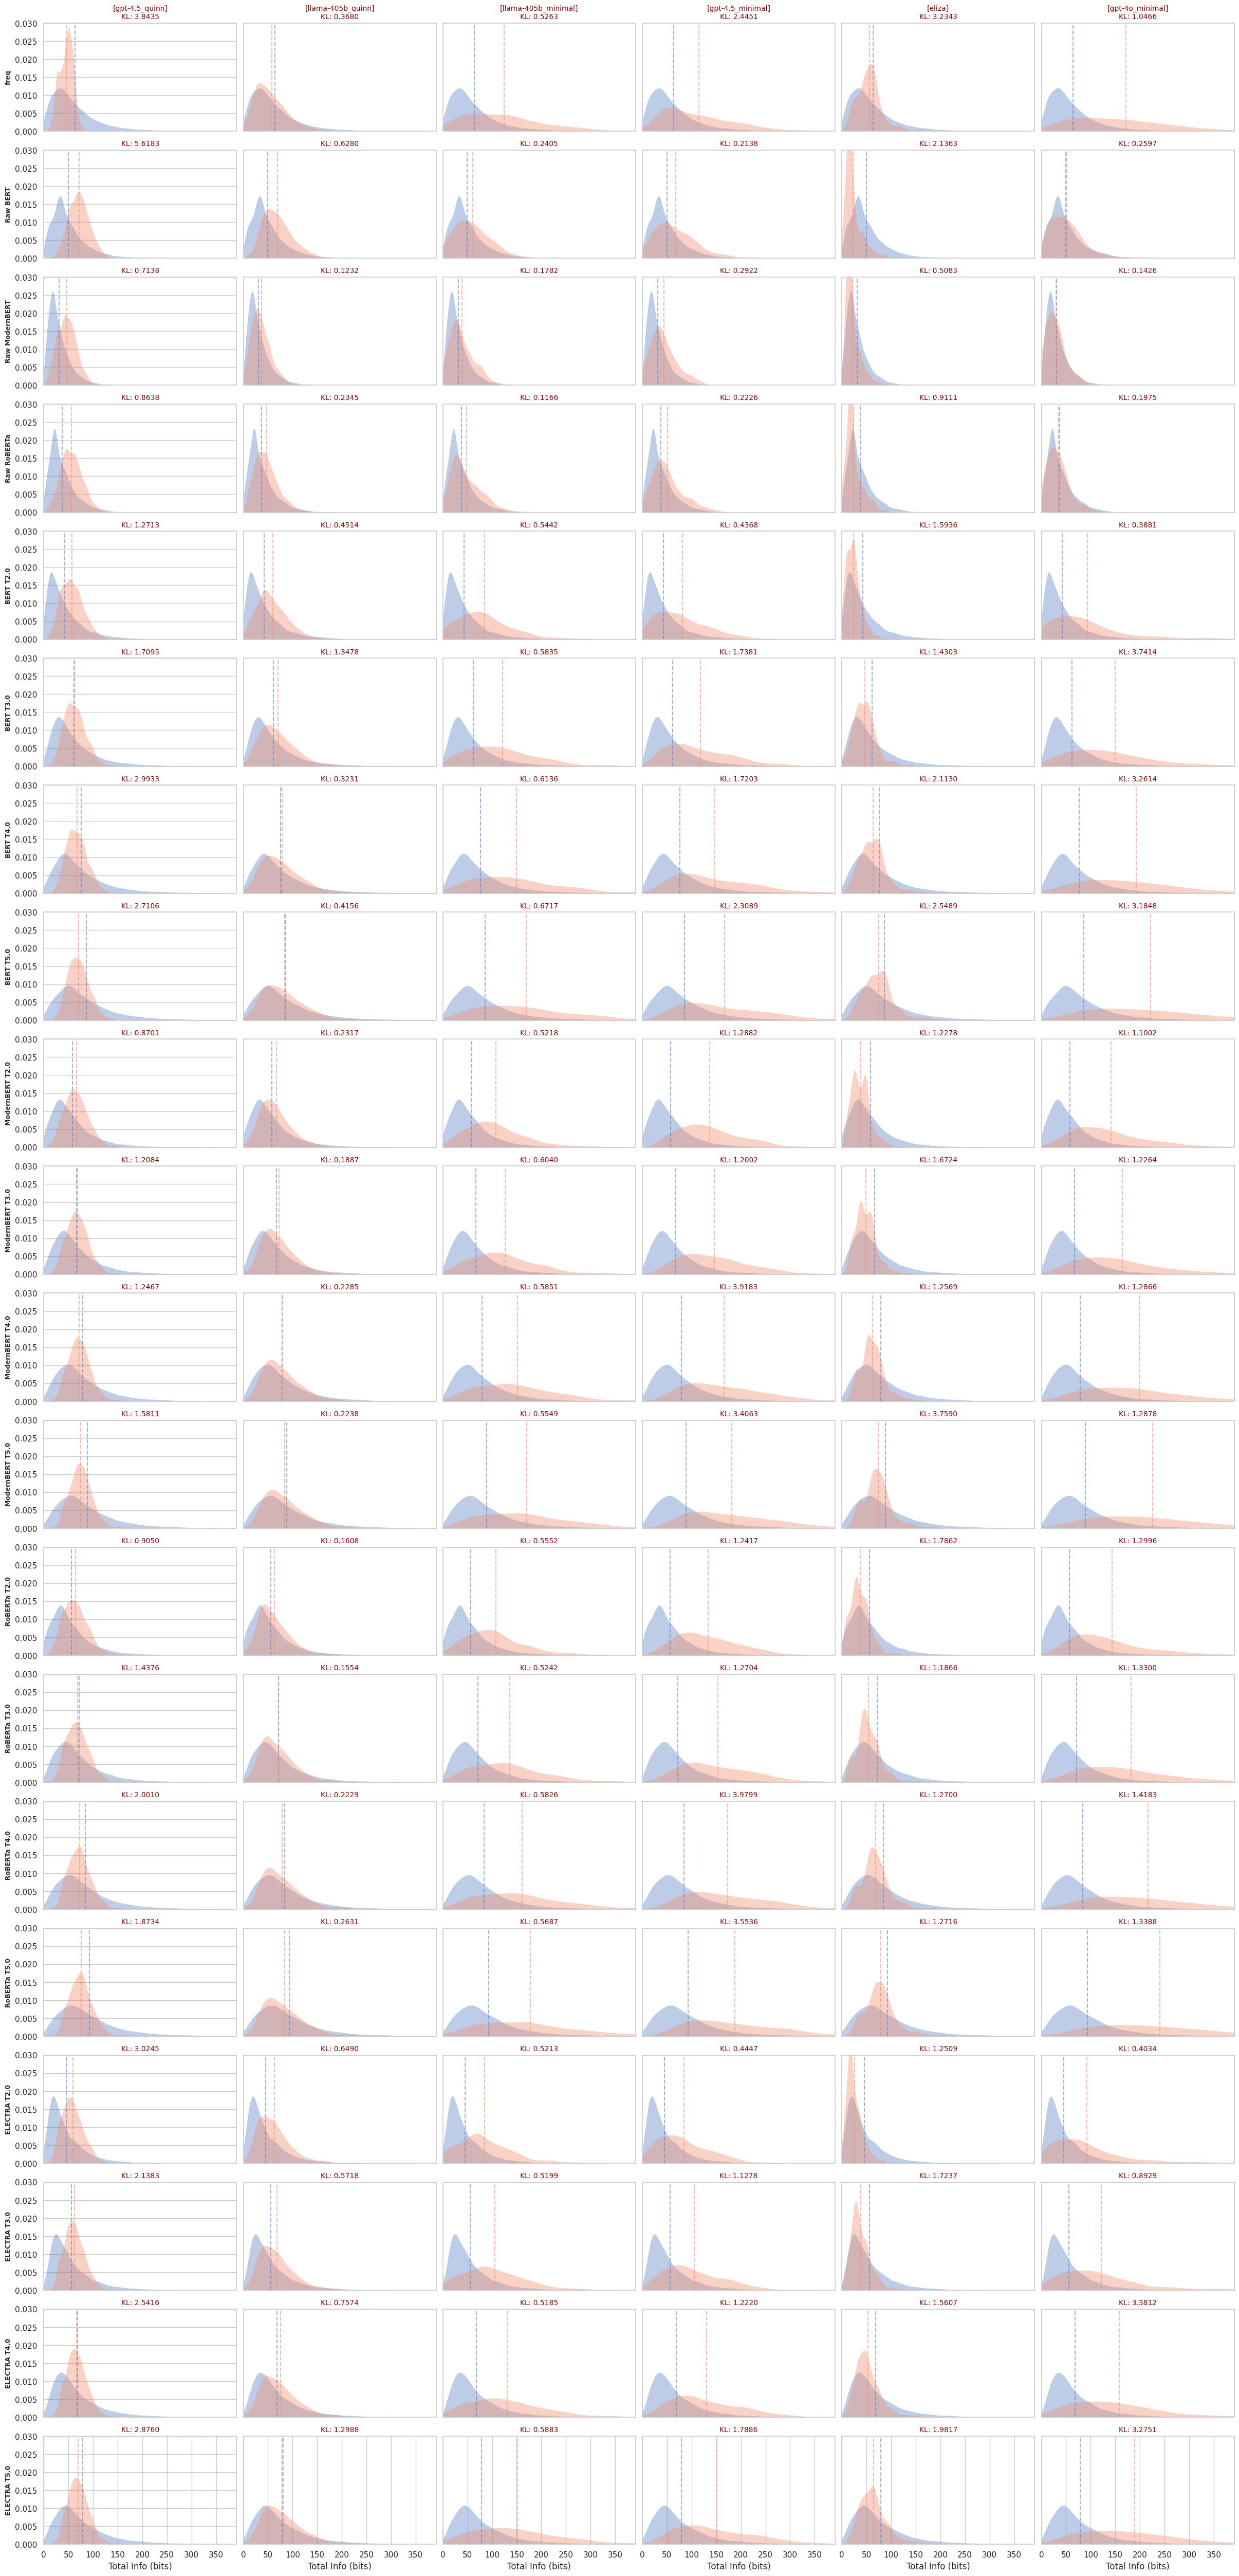


=== KL Divergence Summary ===
             AI_Model  Win_Rate      freq  raw_BERT  raw_ModernBERT  raw_RoBERTa  vq_BERT_T2.0  vq_BERT_T3.0  vq_BERT_T4.0  vq_BERT_T5.0  vq_ModernBERT_T2.0  vq_ModernBERT_T3.0  vq_ModernBERT_T4.0  vq_ModernBERT_T5.0  vq_RoBERTa_T2.0  vq_RoBERTa_T3.0  vq_RoBERTa_T4.0  vq_RoBERTa_T5.0  vq_ELECTRA_T2.0  vq_ELECTRA_T3.0  vq_ELECTRA_T4.0  vq_ELECTRA_T5.0
0       gpt-4.5_quinn      0.73  3.843493  5.618348        0.713772     0.863803      1.271317      1.709462      2.993303      2.710558            0.870107            1.208378            1.246709            1.581082         0.905017         1.437627         2.001036         1.873360         3.024464         2.138284         2.541629         2.875996
1    llama-405b_quinn      0.56  0.367983  0.627954        0.123194     0.234459      0.451405      1.347839      0.323135      0.415611            0.231662            0.188692            0.228546            0.223764         0.160793         0.155368         0.22

In [ ]:
# 메인 루프 (Raw & VQ 계산)
sentences = df_processed['sentence'].tolist()
n_samples = len(sentences)

for exp in EXPERIMENTS:
    name = exp['name']
    path = exp['path']
    hf_id = exp['hf_id']

    print(f"\n Processing: {name}")
    use_trust = True if "ModernBERT" in name else False

    # Raw Model (MLM) Calculation
    if 'electra' in hf_id.lower() and 'discriminator' in hf_id.lower():
        print("  Skipping Raw (Discriminator)")
        df_processed[f'info_raw_{name}'] = np.nan
    else:
        if f'info_raw_{name}' not in df_processed.columns:
            mlm_tokenizer = AutoTokenizer.from_pretrained(hf_id, trust_remote_code=use_trust)
            mlm_model = AutoModelForMaskedLM.from_pretrained(hf_id, trust_remote_code=use_trust).to(device)
            mlm_model.eval()
            df_processed[f'info_raw_{name}'] = compute_mlm_total_entropy_batch(sentences, mlm_model, mlm_tokenizer, device)
            del mlm_model, mlm_tokenizer
            torch.cuda.empty_cache()

    # LLM+VQ Model Calculation
    if os.path.exists(path):
        try:
            base_model = AutoModel.from_pretrained(hf_id, trust_remote_code=use_trust).to(device)
            tokenizer = AutoTokenizer.from_pretrained(hf_id, trust_remote_code=use_trust)

            vqvae = VQVAE_Original_Structure(input_dim=base_model.config.hidden_size).to(device)
            model = VQVAE_Vocab_Classifier(vqvae, vocab_size=base_model.config.vocab_size).to(device)

            # 가중치 로드
            model.load_state_dict(torch.load(path, map_location=device))
            model.eval()

        except Exception as e:
            print(f"  Error loading VQ Checkpoint: {e}")
            continue

        # Inference Loop (에러나면 멈추게)
        for t in TEMPS:
            col_name = f'info_vq_{name}_T{t}'
            print(f"  > Temp {t}...")
            vq_surps = []
            for i in tqdm(range(0, n_samples, BATCH_SIZE), desc=f"VQ {name} T={t}", leave=False):
                batch_sentences = sentences[i : i + BATCH_SIZE]
                vq_surps.extend(compute_vq_vocab_total_surprisal_batch(
                    batch_sentences, model, base_model, tokenizer, device, temperature=t
                ))
            df_processed[col_name] = vq_surps

        del base_model, model, vqvae, tokenizer
        torch.cuda.empty_cache()
    else:
        print(f" Checkpoint not found: {path}")

In [ ]:
# 전체 시각화 (Freq + Raw + All VQ Temps)

metrics_to_plot = ['info_freq']
# Raw 추가
for exp in EXPERIMENTS:
    col = f"info_raw_{exp['name']}"
    if col in df_processed.columns and not df_processed[col].isna().all():
        metrics_to_plot.append(col)
# VQ Temps 추가
for exp in EXPERIMENTS:
    for t in TEMPS:
        col = f"info_vq_{exp['name']}_T{t}"
        if col in df_processed.columns:
            metrics_to_plot.append(col)

ai_sources = sorted([s for s in df_processed['source'].unique() if s != 'human'],
                   key=lambda x: win_rates.get(x, 0), reverse=True)

n_rows = len(metrics_to_plot)
n_cols = len(ai_sources)

# X축 범위 설정
all_numeric = df_processed[metrics_to_plot].select_dtypes(include=[np.number])
global_x_max = all_numeric.quantile(0.99).max()
if global_x_max < 150: global_x_max = 150
global_x_max = min(global_x_max, 600)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 2.5 * n_rows), constrained_layout=True)
human_data = df_processed[df_processed['source'] == 'human']

for r, metric in enumerate(metrics_to_plot):
    h_vals = human_data[metric].dropna()
    label = metric.replace('info_', '').replace('vq_', '').replace('raw_', 'Raw_').replace('_', ' ')

    for c, ai in enumerate(ai_sources):
        ax = axes[r][c] if n_rows > 1 else axes[c]
        ai_vals = df_processed[df_processed['source'] == ai][metric].dropna()

        # Plot
        sns.kdeplot(h_vals, ax=ax, fill=True, color='#5B84C4', alpha=0.4, linewidth=0)
        sns.kdeplot(ai_vals, ax=ax, fill=True, color='#F28E6E', alpha=0.4, linewidth=0)

        # Mean Lines
        ax.axvline(h_vals.mean(), color='#5B84C4', linestyle='--', alpha=0.6)
        if len(ai_vals) > 0:
            ax.axvline(ai_vals.mean(), color='#F28E6E', linestyle='--', alpha=0.6)

        # KL Title
        kl_val = calculate_kl(h_vals, ai_vals)
        title_txt = f"[{ai}]\n" if r == 0 else ""
        kl_str = f"KL: {kl_val:.4f}" if not np.isnan(kl_val) else "KL: NaN"
        ax.set_title(f"{title_txt}{kl_str}", fontsize=10, color='darkred')

        ax.set_xlim(0, global_x_max)
        ax.set_ylim(0, 0.03)

        if c == 0: ax.set_ylabel(label, fontsize=9, fontweight='bold')
        else:
            ax.set_ylabel("")
            ax.set_yticks([])

        if r == n_rows - 1: ax.set_xlabel("Total Info (bits)")
        else:
            ax.set_xlabel("")
            ax.set_xticks([])

plt.show()

In [ ]:
# 요약 출력
summary_rows = []
for ai in ai_sources:
    row_dict = {'AI_Model': ai, 'Win_Rate': win_rates.get(ai, np.nan)}
    for metric in metrics_to_plot:
        kl = calculate_kl(human_data[metric], df_processed[df_processed['source'] == ai][metric])
        row_dict[metric.replace('info_', '')] = kl
    summary_rows.append(row_dict)

df_summary = pd.DataFrame(summary_rows)
print("\n=== KL Divergence Summary ===")
print(df_summary.to_string())

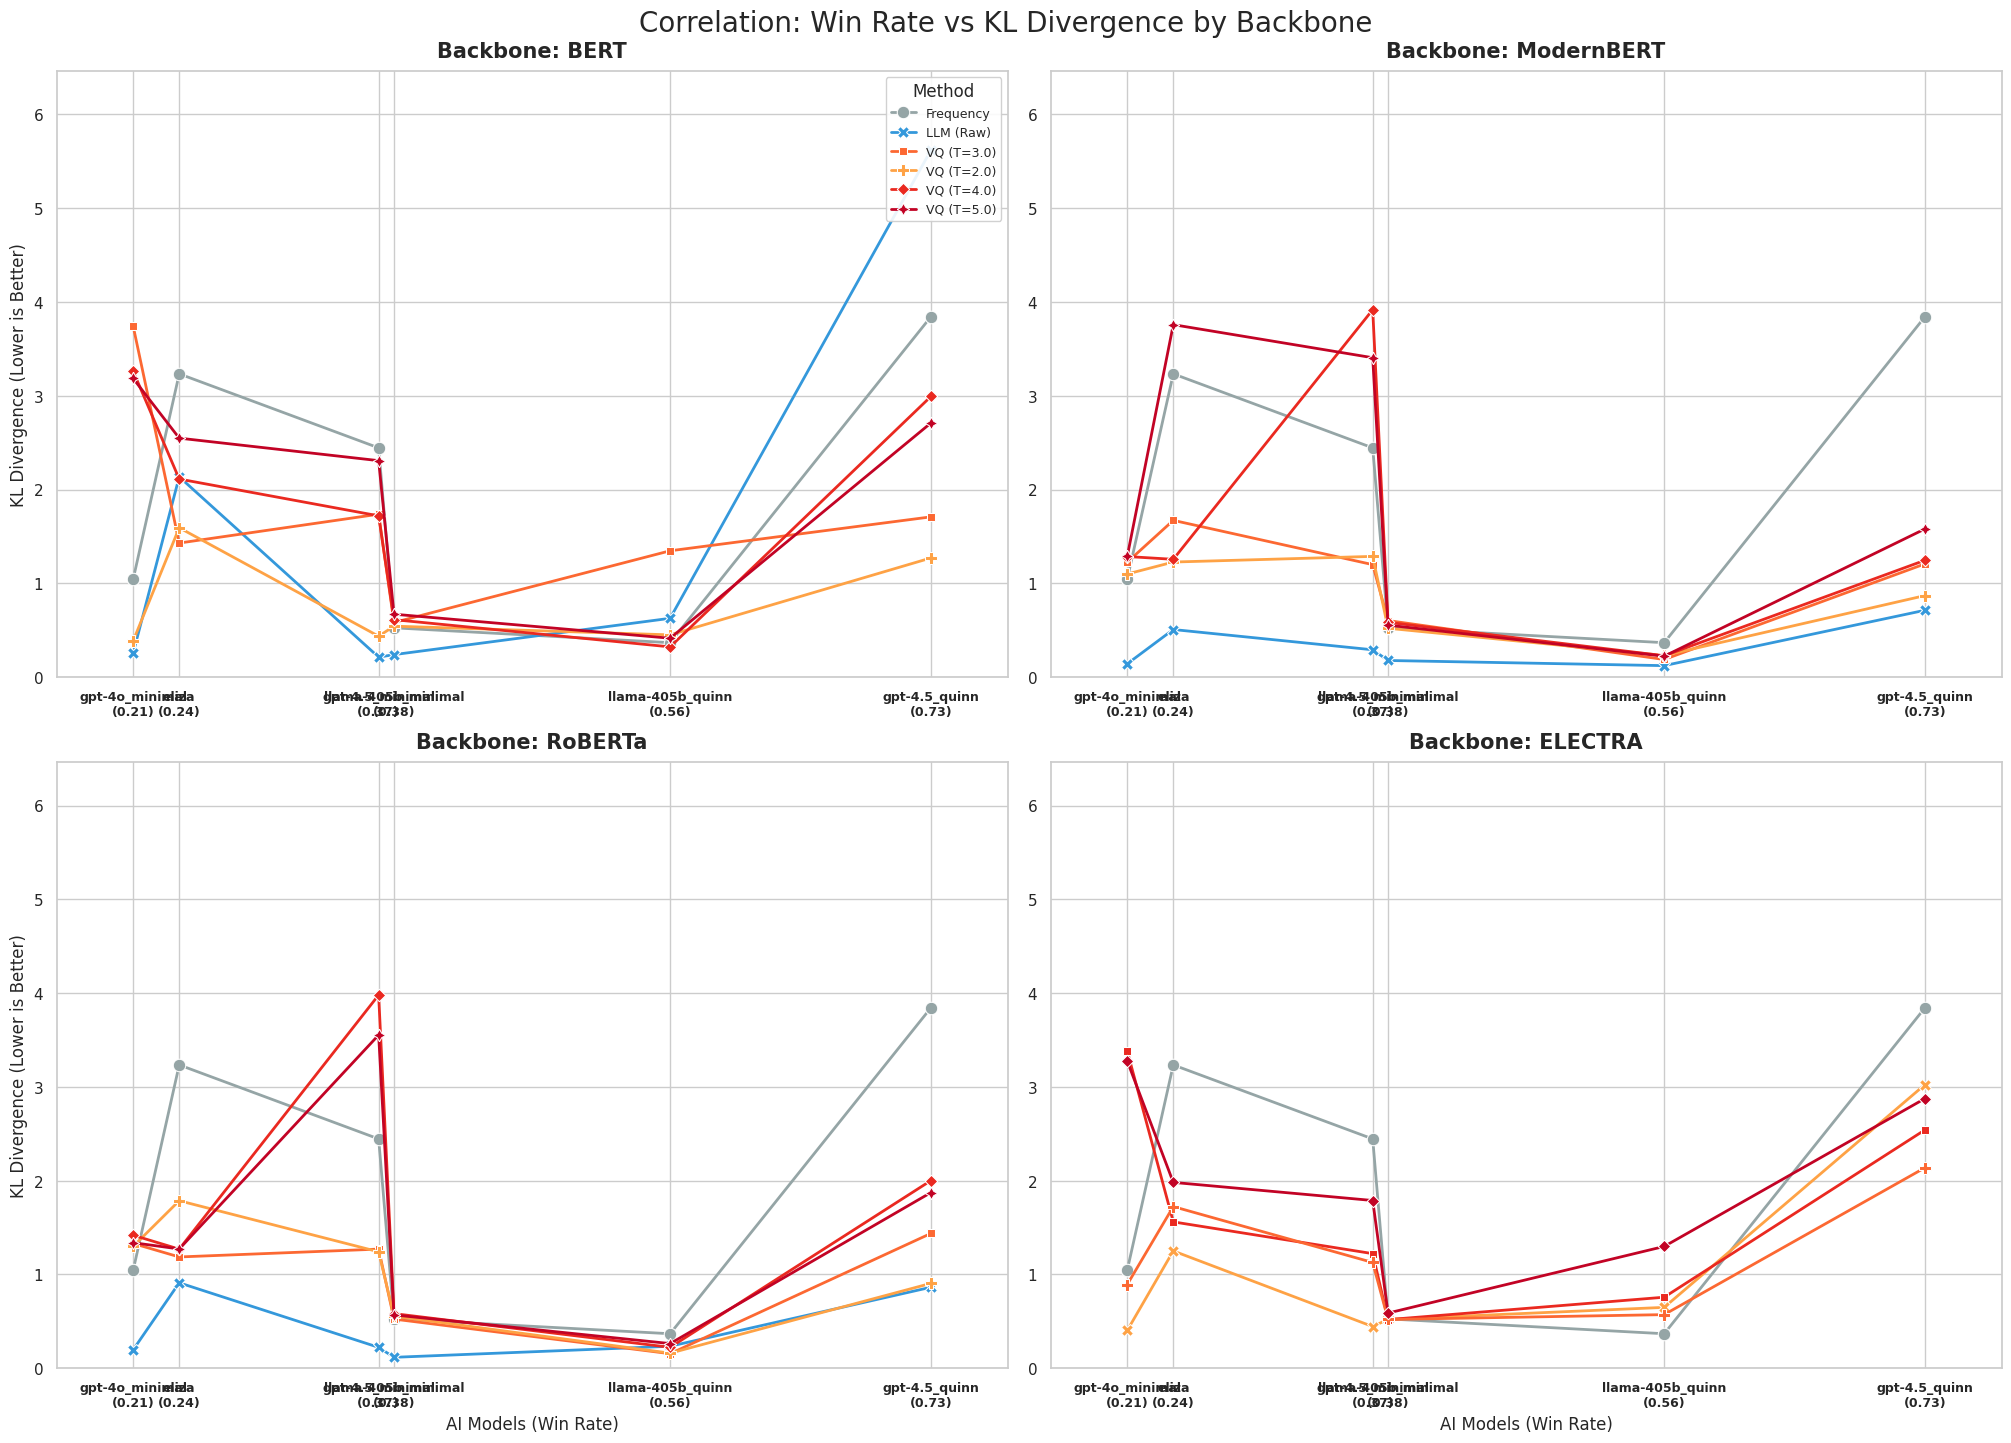

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# 1. 시각화 설정
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(20, 14), constrained_layout=True) # 세로 크기 약간 늘림
axes = axes.flatten()

# Y축 최대값 고정 (전체 데이터 기준)
metric_cols = [c for c in df_summary.columns if c not in ['AI_Model', 'Win_Rate']]
global_y_max = df_summary[metric_cols].max().max() * 1.15

# X축 레이블 생성을 위한 매핑 정보 (Win_Rate -> "ModelName (Rate)")
# 승률 순으로 정렬된 유니크한 승률 값과 모델명을 가져옵니다.
sorted_ai_info = df_summary.sort_values('Win_Rate')
unique_win_rates = sorted_ai_info['Win_Rate'].unique()
# 같은 승률이 있을 수 있으므로 승률별로 모델명을 묶어서 라벨 생성
xtick_labels = []
xtick_vals = []

for rate in unique_win_rates:
    models = sorted_ai_info[sorted_ai_info['Win_Rate'] == rate]['AI_Model'].tolist()
    # 모델명이 길면 앞부분만 따거나 개행문자 넣기 (여기선 간단히 이름만)
    label_str = "\n".join([f"{m}\n({rate:.2f})" for m in models])
    xtick_labels.append(label_str)
    xtick_vals.append(rate)

# 2. 백본 모델별 반복 시각화
for idx, exp in enumerate(EXPERIMENTS):
    ax = axes[idx]
    name = exp['name']

    # 2-1. 데이터 준비
    cols_to_plot = ['freq']
    raw_col = f"raw_{name}"
    if raw_col in df_summary.columns:
        cols_to_plot.append(raw_col)

    vq_cols = [c for c in df_summary.columns if f"vq_{name}_T" in c]
    cols_to_plot.extend(sorted(vq_cols))

    plot_df = df_summary.melt(id_vars=['AI_Model', 'Win_Rate'], value_vars=cols_to_plot,
                              var_name='Method', value_name='KL_Divergence')
    plot_df = plot_df.sort_values(by='Win_Rate')

    # Label 정리
    def clean_label(s):
        if s == 'freq': return 'Frequency'
        if 'raw' in s: return 'LLM (Raw)'
        t_val = s.split('_T')[-1]
        return f"VQ (T={t_val})"

    plot_df['Label'] = plot_df['Method'].apply(clean_label)

    # 색상 설정
    palette = {'Frequency': '#95a5a6'}
    if raw_col in df_summary.columns:
        palette['LLM (Raw)'] = '#3498db'

    vq_colors = sns.color_palette("YlOrRd", len(vq_cols) + 2)[2:]
    for i, vq_c in enumerate(sorted(vq_cols)):
        t_val = vq_c.split('_T')[-1]
        palette[f"VQ (T={t_val})"] = vq_colors[i]

    # 2-2. 선 그래프 그리기
    sns.lineplot(
        data=plot_df,
        x='Win_Rate',
        y='KL_Divergence',
        hue='Label',
        style='Label',
        markers=True,
        dashes=False,
        palette=palette,
        ax=ax,
        linewidth=2,
        markersize=9
    )

    # 2-3. X축 커스텀 설정
    ax.set_xticks(xtick_vals) # 데이터가 존재하는 승률 위치에만 눈금 표시
    ax.set_xticklabels(xtick_labels, fontsize=9, fontweight='bold') # 모델명+승률 레이블 적용

    # 그래프 꾸미기
    ax.set_title(f"Backbone: {name}", fontsize=15, fontweight='bold', pad=10)

    # X축 범위: 최소 승률보다 조금 왼쪽 ~ 최대 승률보다 조금 오른쪽 (여백 확보)
    min_rate = min(xtick_vals)
    max_rate = max(xtick_vals)
    padding = 0.05
    ax.set_xlim(min_rate - padding, max_rate + padding)

    ax.set_ylim(0, global_y_max)
    ax.set_xlabel("AI Models (Win Rate)" if idx >= 2 else "")
    ax.set_ylabel("KL Divergence (Lower is Better)" if idx % 2 == 0 else "")

    # 범례 설정
    if idx == 0:
        ax.legend(title="Method", loc='upper right', fontsize=9, framealpha=0.9)
    else:
        ax.legend([],[], frameon=False)

plt.suptitle("Correlation: Win Rate vs KL Divergence by Backbone", fontsize=20, y=1.02)
plt.show()


Processing: BERT

Processing: ModernBERT

Processing: RoBERTa


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Processing: ELECTRA
  Skipping Raw (Discriminator)

Calculating Metrics (KL, JSD, EMD)...

Drawing Line Plots for KL, JSD, EMD...


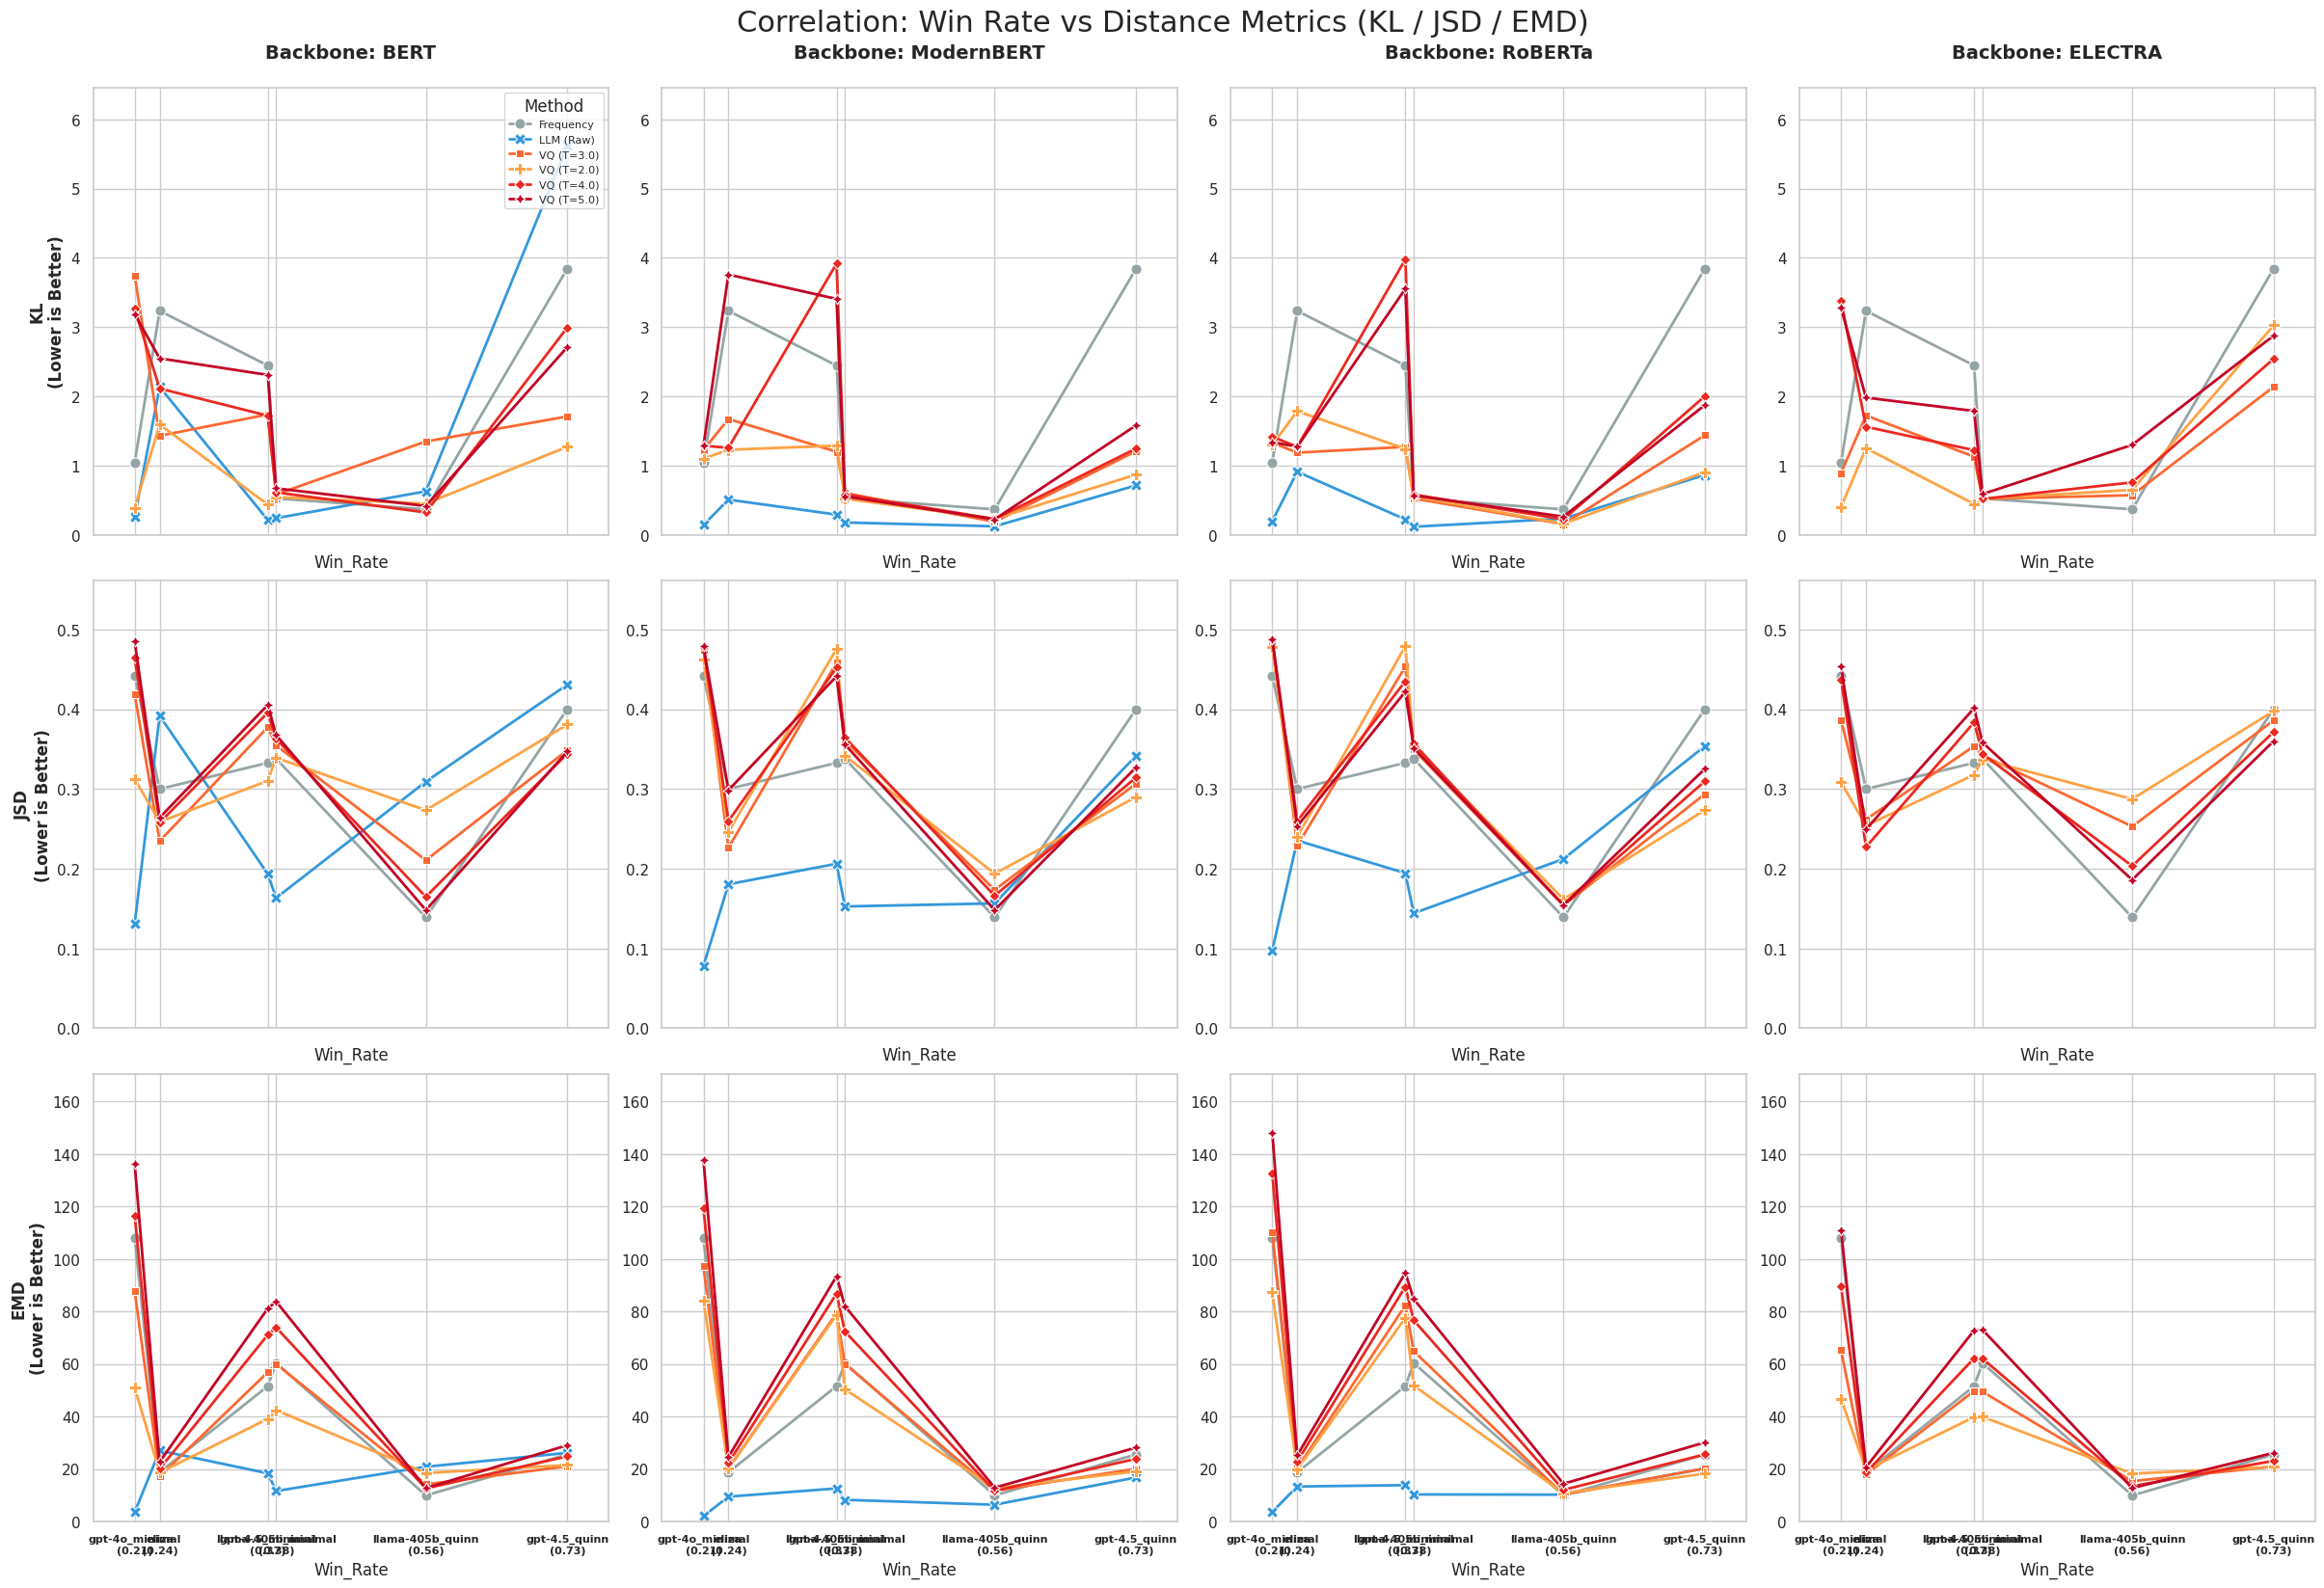

In [ ]:
# 1. 3가지 분포 거리 지표 계산 함수 (KL, JSD, EMD)
def calculate_metrics(p, q, n_bins=50):
    """
    Human(p)과 AI(q)의 분포 차이를 3가지 척도(KL, JSD, EMD)로 계산
    """
    p, q = p.dropna(), q.dropna()
    if len(p) < 5 or len(q) < 5:
        return {'KL': np.nan, 'JSD': np.nan, 'EMD': np.nan}

    # 1) EMD (Wasserstein): 물리적 거리 (Raw 데이터 사용)
    emd_val = wasserstein_distance(p, q)

    # 2) 확률 분포 생성 (KL, JSD용)
    min_v, max_v = min(p.min(), q.min()), max(p.max(), q.max())
    bins = np.linspace(min_v, max_v, n_bins+1)

    p_c, _ = np.histogram(p, bins=bins)
    q_c, _ = np.histogram(q, bins=bins)

    # 스무딩 (0 나누기 방지)
    p_prob = (p_c + 1e-10) / (p_c + 1e-10).sum()
    q_prob = (q_c + 1e-10) / (q_c + 1e-10).sum()

    # 3) KL & JSD 계산
    kl_val = entropy(p_prob, q_prob)
    jsd_val = jensenshannon(p_prob, q_prob) # 0~1 사이 값

    return {'KL': kl_val, 'JSD': jsd_val, 'EMD': emd_val}

# 2. 메인 루프: 정보량(Surprisal) 추출
sentences = df_processed['sentence'].tolist()
n_samples = len(sentences)

for exp in EXPERIMENTS:
    name = exp['name']
    path = exp['path']
    hf_id = exp['hf_id']

    print(f"\nProcessing: {name}")
    use_trust = True if "ModernBERT" in name else False

    # [Raw Model] MLM Entropy 계산
    if 'electra' in hf_id.lower() and 'discriminator' in hf_id.lower():
        print("  Skipping Raw (Discriminator)")
        df_processed[f'info_raw_{name}'] = np.nan
    else:
        if f'info_raw_{name}' not in df_processed.columns:
            mlm_tokenizer = AutoTokenizer.from_pretrained(hf_id, trust_remote_code=use_trust)
            mlm_model = AutoModelForMaskedLM.from_pretrained(hf_id, trust_remote_code=use_trust).to(device)
            mlm_model.eval()

            # 배치 계산
            df_processed[f'info_raw_{name}'] = compute_mlm_total_entropy_batch(
                sentences, mlm_model, mlm_tokenizer, device
            )
            del mlm_model, mlm_tokenizer
            torch.cuda.empty_cache()

    # [VQ Model] VQ Surprisal 계산 (Temp 별)
    if os.path.exists(path):
        try:
            base_model = AutoModel.from_pretrained(hf_id, trust_remote_code=use_trust).to(device)
            tokenizer = AutoTokenizer.from_pretrained(hf_id, trust_remote_code=use_trust)

            vqvae = VQVAE_Original_Structure(input_dim=base_model.config.hidden_size).to(device)
            model = VQVAE_Vocab_Classifier(vqvae, vocab_size=base_model.config.vocab_size).to(device)

            model.load_state_dict(torch.load(path, map_location=device))
            model.eval()

        except Exception as e:
            print(f"  Error loading VQ Checkpoint: {e}")
            continue

        for t in TEMPS:
            col_name = f'info_vq_{name}_T{t}'
            if col_name not in df_processed.columns:
                print(f"  > Temp {t}...")
                vq_surps = []
                for i in tqdm(range(0, n_samples, BATCH_SIZE), desc=f"VQ {name} T={t}", leave=False):
                    batch = sentences[i : i + BATCH_SIZE]
                    vq_surps.extend(compute_vq_vocab_total_surprisal_batch(
                        batch, model, base_model, tokenizer, device, temperature=t
                    ))
                df_processed[col_name] = vq_surps

        del base_model, model, vqvae, tokenizer
        torch.cuda.empty_cache()
    else:
        print(f"  Checkpoint not found: {path}")

# 3. 데이터 집계 (Human vs AI 거리 계산)
print("\nCalculating Metrics (KL, JSD, EMD)...")

summary_rows = []
human_data = df_processed[df_processed['source'] == 'human']
ai_sources = sorted([s for s in df_processed['source'].unique() if s != 'human'],
                   key=lambda x: win_rates.get(x, 0), reverse=True)

for ai in ai_sources:
    ai_df = df_processed[df_processed['source'] == ai]
    row = {'AI_Model': ai, 'Win_Rate': win_rates.get(ai, np.nan)}

    # (1) Freq Metrics
    m = calculate_metrics(human_data['info_freq'], ai_df['info_freq'])
    row['freq_KL'], row['freq_JSD'], row['freq_EMD'] = m['KL'], m['JSD'], m['EMD']

    # (2) Backbone별 Metrics
    for exp in EXPERIMENTS:
        name = exp['name']

        # Raw
        if f'info_raw_{name}' in df_processed.columns:
            m = calculate_metrics(human_data[f'info_raw_{name}'], ai_df[f'info_raw_{name}'])
            row[f'raw_{name}_KL'], row[f'raw_{name}_JSD'], row[f'raw_{name}_EMD'] = m['KL'], m['JSD'], m['EMD']

        # VQ Temps
        for t in TEMPS:
            col = f'info_vq_{name}_T{t}'
            if col in df_processed.columns:
                m = calculate_metrics(human_data[col], ai_df[col])
                row[f'vq_{name}_T{t}_KL'], row[f'vq_{name}_T{t}_JSD'], row[f'vq_{name}_T{t}_EMD'] = m['KL'], m['JSD'], m['EMD']

    summary_rows.append(row)

df_summary = pd.DataFrame(summary_rows)

# 4. 시각화: 3가지 지표(행) x 4가지 백본(열) 선 그래프
print("\nDrawing Line Plots for KL, JSD, EMD...")

METRICS_TO_SHOW = ['KL', 'JSD', 'EMD']
sns.set_theme(style="whitegrid")

# X축 레이블 생성 (모델명 + 승률)
sorted_ai = df_summary.sort_values('Win_Rate')
xtick_vals = sorted_ai['Win_Rate'].unique()
xtick_labels = []
for rate in xtick_vals:
    models = sorted_ai[sorted_ai['Win_Rate'] == rate]['AI_Model'].tolist()
    label_str = "\n".join([f"{m}\n({rate:.2f})" for m in models])
    xtick_labels.append(label_str)

# 3행(Metric) x 4열(Backbone) 그래프
fig, axes = plt.subplots(3, 4, figsize=(24, 16), constrained_layout=True)

for row_idx, metric_type in enumerate(METRICS_TO_SHOW):     # 행: 지표 종류 (KL, JSD, EMD)

    # Y축 통일 (해당 Metric 내에서 Max값 찾기)
    relevant_cols = [c for c in df_summary.columns if c.endswith(f'_{metric_type}')]
    y_max = df_summary[relevant_cols].max().max() * 1.15

    for col_idx, exp in enumerate(EXPERIMENTS):             # 열: 백본 종류
        ax = axes[row_idx][col_idx]
        name = exp['name']

        # Plot용 데이터 준비 (Melt)
        cols = [f'freq_{metric_type}']
        if f'raw_{name}_{metric_type}' in df_summary.columns:
            cols.append(f'raw_{name}_{metric_type}')

        vq_cols = [c for c in df_summary.columns if f'vq_{name}_T' in c and c.endswith(f'_{metric_type}')]
        cols.extend(sorted(vq_cols))

        plot_df = df_summary.melt(id_vars=['AI_Model', 'Win_Rate'], value_vars=cols,
                                  var_name='Method_Full', value_name='Value').sort_values('Win_Rate')

        # 범례용 라벨 정리
        def clean_label(s):
            if 'freq' in s: return 'Frequency'
            if 'raw' in s: return 'LLM (Raw)'
            # vq_BERT_T2.0_KL -> VQ (T=2.0)
            t = s.split('_T')[-1].split('_')[0]
            return f"VQ (T={t})"

        plot_df['Label'] = plot_df['Method_Full'].apply(clean_label)

        # 색상 매핑
        palette = {'Frequency': '#95a5a6'}
        if f'raw_{name}_{metric_type}' in df_summary.columns:
            palette['LLM (Raw)'] = '#3498db'

        # VQ 그라데이션
        unique_vq = sorted([l for l in plot_df['Label'].unique() if 'VQ' in l])
        vq_colors = sns.color_palette("YlOrRd", len(unique_vq) + 2)[2:]
        for i, lab in enumerate(unique_vq):
            palette[lab] = vq_colors[i]

        # 선 그래프
        sns.lineplot(data=plot_df, x='Win_Rate', y='Value', hue='Label', style='Label',
                     markers=True, dashes=False, palette=palette, ax=ax, linewidth=2, markersize=8)

        # 축 및 타이틀 설정
        ax.set_xticks(xtick_vals)
        ax.set_xticklabels(xtick_labels if row_idx == 2 else [], fontsize=8, fontweight='bold') # 맨 밑에만 레이블
        ax.set_xlim(min(xtick_vals)-0.05, max(xtick_vals)+0.05)
        ax.set_ylim(0, y_max)

        # 타이틀
        title_txt = ""
        if row_idx == 0: title_txt += f"Backbone: {name}\n"
        if col_idx == 0: ax.set_ylabel(f"{metric_type}\n(Lower is Better)", fontsize=12, fontweight='bold')
        else: ax.set_ylabel("")

        ax.set_title(title_txt, fontsize=14, fontweight='bold')

        # 범례
        if row_idx == 0 and col_idx == 0:
            ax.legend(title="Method", loc='upper right', fontsize=8)
        else:
            ax.legend([],[], frameon=False)

plt.suptitle("Correlation: Win Rate vs Distance Metrics (KL / JSD / EMD)", fontsize=22, y=1.02)
plt.show()